In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt

from ssm.models import HMM, SLDS, LDS
from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter

In [2]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [3]:
# Run PCA to get a 3d projection of the data
from scipy.ndimage import gaussian_filter1d
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(4, ys, ms)
xs = [gaussian_filter1d(x, 1, axis=0) for x in xs]
# dxs = [gaussian_filter1d(np.gradient(x, axis=0), 1, axis=0) for x in xs]

lim = 1.1 * abs(np.vstack(xs)).max()

In [4]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.stats import norm

from ssm.observations import _Observations
from ssm.util import logistic, logit

class SimpleARObservations(_Observations):
    def __init__(self, K, D, M=0):
        super(SimpleARObservations, self).__init__(K, D, M)
        
        # Distribution over initial point
        self.mu_init = np.zeros(D)
        self.inv_sigma_init = np.zeros(D)
        
        # AR parameters
        self.As = 0.9 * np.ones((K, D))
        self.bs = npr.randn(K, D)
        self.inv_sigmas = -4 + npr.randn(K, D)

    @property
    def params(self):
        return self.As, self.bs, self.inv_sigmas
        
    @params.setter
    def params(self, value):
        self.As, self.bs, self.inv_sigmas = value
        
    def permute(self, perm):
        self.As = self.As[perm]
        self.bs = self.bs[perm]
        self.inv_sigmas = self.inv_sigmas[perm]

    def initialize(self, datas, inputs=None, masks=None, tags=None):
        # Initialize with linear regressions
        from sklearn.linear_model import LinearRegression
        data = np.concatenate(datas) 
        T = data.shape[0]

        for k in range(self.K):
            ts = npr.choice(T-1, replace=False, size=(T-1)//self.K)
            x = np.column_stack([data[ts + l] for l in range(1)])
            y = data[ts+1]
            lr = LinearRegression().fit(x, y)
            self.As[k] = np.diag(lr.coef_)
            self.bs[k] = lr.intercept_
            
            resid = y - lr.predict(x)
            sigmas = np.var(resid, axis=0)
            self.inv_sigmas[k] = np.log(sigmas + 1e-8)
        
    def _compute_mus(self, data, input, mask, tag):
        T, D = data.shape
        
        # Random walk dynamics
        mus = self.As * data[:-1, None, :] + self.bs
        
        # Pad with the initial condition
        mus = np.concatenate((self.mu_init * np.ones((1, self.K, self.D)), mus))

        assert mus.shape == (T, self.K, D)
        return mus

    def log_likelihoods(self, data, input, mask, tag):
        mus = self._compute_mus(data, input, mask, tag)
        sigmas = np.exp(self.inv_sigmas)
        return -0.5 * np.sum(
            (np.log(2 * np.pi * sigmas) + (data[:, None, :] - mus)**2 / sigmas) 
            * mask[:, None, :], axis=2)

    def m_step(self, expectations, datas, inputs, masks, tags, **kwargs):
        from sklearn.linear_model import LinearRegression
        D = self.D

        xs = np.concatenate([data[:-1] for data in datas])
        ys = np.concatenate([data[1:] for data in datas])

        for k in range(self.K):
            ws = np.concatenate([Ez[1:, k] for (Ez, _) in expectations])
            
            if np.isclose(np.sum(ws), 0):
                self.As[k] = 1
                self.bs[k] = 0
                continue

            # incorporate masks into the weights
            weights = ws[:, None] * np.concatenate([mask[1:] for mask in masks])
            
            # reweight the inputs and ouputs
            xr = xs * np.sqrt(weights)
            yr = ys * np.sqrt(weights)
            
            # make regression matrices (x^T x) where x = [xr, sqrt(weights)].  
            xxs = np.zeros((D, 2, 2))
            xxs[:, 0, 0] = np.sum(xr**2, axis=0)
            xxs[:, 0, 1] = xxs[:, 1, 0] = np.sum(xr, axis=0)
            xxs[:, 1, 1] = np.sum(weights)
            
            # make regression matrices x^T y
            xys = np.zeros((D, 2))
            xys[:, 0] = np.sum(xr * yr, axis=0)
            xys[:, 1] = np.sum(weights * ys, axis=0)
            
            # add a bit of regularization: center on a=1, b=0
            xxs += np.eye(2)
            xys += np.array([1, 0])
            
            # solve the regressions
            coefs = np.linalg.solve(xxs, xys)
            assert coefs.shape == (D, 2)
            self.As[k] = coefs[:, 0]
            self.bs[k] = coefs[:, 1]
            
            # set the variances
            yhats = self.As[k] * xs + self.bs[k]
            sqerr = (ys - yhats)**2
            sqerr[0] += .1
            weights[0] += 1
            self.inv_sigmas[k] = np.log(np.average(sqerr, weights=weights, axis=0))
        
#     def sample_x(self, z, xhist, input=None, tag=None):
#         D, As, bs, sigmas = self.D, self.As, self.bs, np.exp(self.inv_sigmas)
#         if xhist.shape[0] < self.lags:
#             mu_init = self.mu_init
#             sigma_init = np.exp(self.inv_sigma_init)
#             return mu_init + np.sqrt(sigma_init) * npr.randn(D)
#         else:
#             mu = bs[z]
#             for l in range(self.lags):
#                 mu += As[z][:,l*D:(l+1)*D].dot(xhist[-l-1])
#             return np.sqrt(sigmas[z]) * npr.randn(D)

    def smooth(self, expectations, data, input, tag):
        """
        Compute the mean observation under the posterior distribution
        of latent discrete states.
        """
        T = expectations.shape[0]
        mask = np.ones((T, self.D), dtype=bool) 
        mus = self._compute_mus(data, input, mask, tag)
        return (expectations[:, :, None] * mus).sum(1)

In [5]:
from ssm.transitions import RecurrentTransitions
from ssm.init_state_distns import InitialStateDistribution
from ssm.core import _HMM

K = 8
hmm = _HMM(K, N, 0, 
          InitialStateDistribution(K, N),
          RecurrentTransitions(K, N, M=0),
          SimpleARObservations(K, N))


In [6]:
lls = hmm.fit(ys[:1], masks=ms[:1], method="em", num_em_iters=50)

Iteration 0.  LL: 189136.7
Iteration 1.  LL: 191447.1
Iteration 2.  LL: 191509.4
Iteration 3.  LL: 191111.4
Iteration 4.  LL: 191097.2
Iteration 5.  LL: 191055.4
Iteration 6.  LL: 190970.6
Iteration 7.  LL: 190197.4
Iteration 8.  LL: 190184.0
Iteration 9.  LL: 190195.5
Iteration 10.  LL: 190143.0
Iteration 11.  LL: 190088.4
Iteration 12.  LL: 190066.9
Iteration 13.  LL: 190090.0
Iteration 14.  LL: 190076.9
Iteration 15.  LL: 190052.7
Iteration 16.  LL: 190015.4
Iteration 17.  LL: 189958.9
Iteration 18.  LL: 189984.8
Iteration 19.  LL: 189967.2
Iteration 20.  LL: 189925.1
Iteration 21.  LL: 189935.9
Iteration 22.  LL: 189948.0
Iteration 23.  LL: 189940.1
Iteration 24.  LL: 189923.4
Iteration 25.  LL: 189934.9
Iteration 26.  LL: 189917.3
Iteration 27.  LL: 189909.8
Iteration 28.  LL: 189991.5
Iteration 29.  LL: 189976.7
Iteration 30.  LL: 189982.8
Iteration 31.  LL: 189983.1
Iteration 32.  LL: 189997.5
Iteration 33.  LL: 190009.3
Iteration 34.  LL: 190031.8
Iteration 35.  LL: 190021.1
It

In [7]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [8]:
zs = [hmm.most_likely_states(y, mask=m) for y, m in zip(ys, ms)]

Text(0.5,0.98,'Continuous Latent States (HMM Labels)')

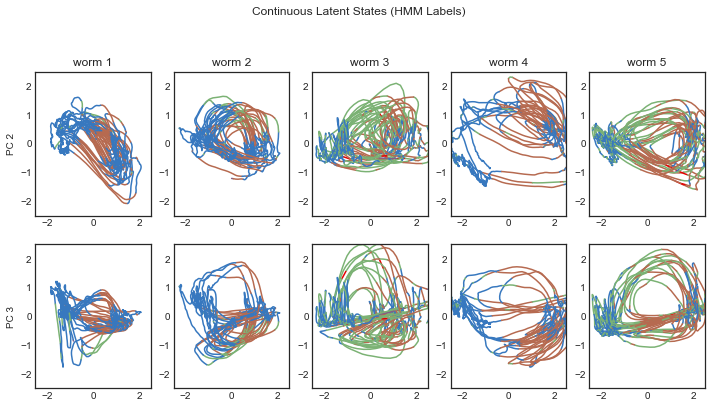

In [9]:
colors = np.vstack((zplt.default_colors, zplt.default_colors))

plt.figure(figsize=(12, 9))
for w, (x, z) in enumerate(zip(xs, zs)):
    ax = plt.subplot(3, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-2.5, 2.5), ylims=(-2.5, 2.5), inds=(0, 1), ax=ax, colors=colors)
    plt.ylabel("PC 2" if w == 0 else "")
    plt.title("worm {}".format(w+1))

    ax = plt.subplot(3, W, W+w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-2.5, 2.5), ylims=(-2.5, 2.5), inds=(0, 2), ax=ax, colors=colors)
    plt.ylabel("PC 3" if w == 0 else "")
    
plt.suptitle("Continuous Latent States (HMM Labels)")

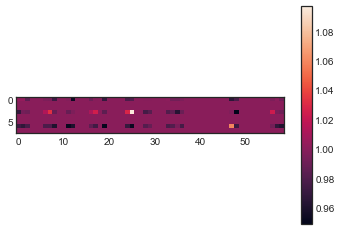

In [10]:
plt.imshow(hmm.observations.As)
plt.colorbar()